# psychothreshold - Time varying

In [21]:
import numpy as np
import random

# RTDs in real and scaled time units should match
ILD_arr  = [2]
ABL_arr = [40]

t_non_decision = 0
rate_lambda = 0.01
T_0 = 0.1 * 1e-3
theta_E = 30
dt = 1e-4
c = 0.2


def tied_abs_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    DV = 0; t = 0
    chi = 17.37
    dB = np.sqrt(dt)

    c = 0.2
    while True:
        mu = (2/T_0) * (10**(rate_lambda*ABL/20)) * (rate_lambda * ILD / chi) * (1/c)*np.exp(-t/c)
        sigma = np.sqrt((2/T_0)* (10**(rate_lambda*ABL/20)) * (1/c)*np.exp(-t/c))

        DV += mu*dt + sigma * np.random.normal(0, dB)
        t += dt

        # bounds are +1 and -1 as simulation is done in normalized units
        if DV >= theta_E or DV <= -theta_E:
            return t
        

def tied_rescaled_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    DV = 0; t = 0
    chi = 17.37
    c = 0.2
    dB = np.sqrt(dt)

    while True:
        mu = (rate_lambda * theta_E * ILD / chi) 
        sigma = 1

        DV += mu*dt + sigma * np.random.normal(0, dB)
        t += dt
        
        if DV >= 1 or DV <= -1:
            return t

    

In [22]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [23]:
N_sim = int(10e3)
rt_abs = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
print('abs done')
rt_rescaled = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

abs done


Text(0.5, 1.0, 'abs vs rescaled')

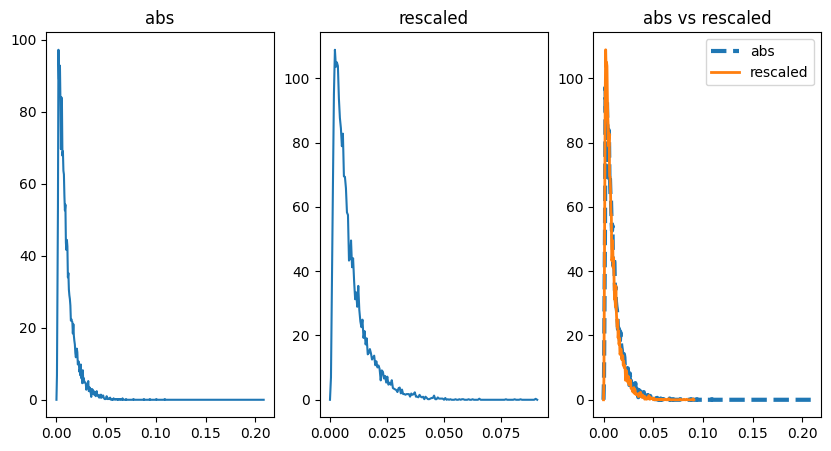

In [24]:
bins = np.arange(0, max(rt_abs) + 0.1, 5e-4)

# abs
abs_hist, _ = np.histogram(rt_abs, bins=bins, density=True)
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.plot(bins[:-1], abs_hist)
plt.title('abs')
# rescaled
bins_in_tau = np.arange(0, max(rt_rescaled) + 0.1, 0.05)
rescaled_hist, _ = np.histogram(rt_rescaled, bins=bins_in_tau, density=True)

A = (2 / (T_0 * (theta_E ** 2))) * (10 ** (rate_lambda * ABL_arr[0] / 20))
bins_in_t_from_tau = -c * np.log(1 - bins_in_tau / A)

dtau_by_dt = (2 / (T_0 * (theta_E**2))) * (10**(rate_lambda*ABL_arr[0]/20)) * (1/c)*(np.exp(-bins_in_t_from_tau[:-1]/c))
rescaled_hist_times_dtau_dt = rescaled_hist * dtau_by_dt

plt.subplot(1,3,2)
plt.plot(bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt)
plt.title('rescaled')
plt.subplot(1,3,3)
# plot both
plt.plot(bins[:-1], abs_hist, label='abs', ls='--', lw=3)
plt.plot(bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt, label='rescaled', lw=2)
plt.legend()
plt.title('abs vs rescaled')

# for diff ABL ?

In [27]:
ABL_arr = [60]
abl_60_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

print('60 done')
ABL_arr = [20]
abl_20_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))


60 done


Text(0.5, 1.0, 'ABL 60 vs 20')

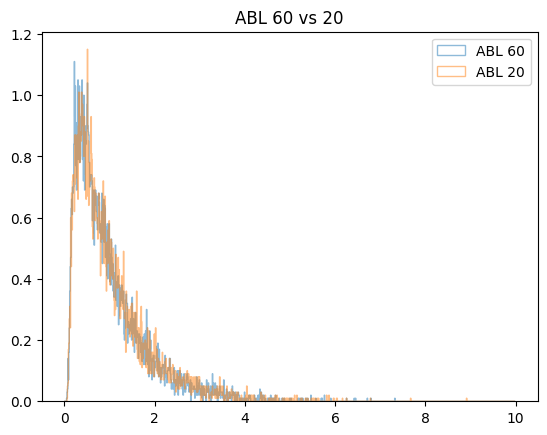

In [30]:
np.max(abl_60_rel_rt), np.max(abl_20_rel_rt)
bins = np.arange(0, 10, 0.01)
plt.hist(abl_60_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 60', histtype='step')
plt.hist(abl_20_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 20', histtype='step')

plt.legend()
plt.title('ABL 60 vs 20')